<a href="https://www.kaggle.com/code/catalystcooperative/03-eia-930-sanity-checks?scriptVersionId=257400259" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!mamba install matplotx --quiet --yes

warning  libmamba Cache file "/opt/conda/pkgs/cache/c6f2354e.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/86b0f08d.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/c9ddbd6b.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/b121c3e7.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/497deca9.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/09cdf8bf.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/47929eba.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/3e39a7aa.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/2ce54b42.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/4ea078d6.json" was modified by another program
Preparing 

In [2]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import matplotx
matplotlib.style.use(matplotx.styles.onedark)

## Where is the PUDL data?
- PUDL data can be read from the [PUDL AWS Open Data Registry](https://registry.opendata.aws/catalyst-cooperative-pudl/) S3 bucket.
- The bucket URL is `s3://pudl.catalyst.coop` and the contents are organized by version.
- The most recent successful nightly build outputs are at `/nightly`
- We can define a little helper function below that takes a table name and pulls the most recent nightly version of that table.
- Because this data is being read from a remote location, there's a bit of a lag for each query.
- How long that lag is will depend on the speed of your network connection and the size of the data you're trying to read.

In [3]:
import pyarrow.parquet as pq
# If you wanted to pull a different version of the data, swap the version string in for /nightly here
PARQUET_PATH = "s3://pudl.catalyst.coop/nightly"

def read_parquet(table_name: str) -> pd.DataFrame | gpd.GeoDataFrame:
    """A helper function to read PUDL Parquet files."""
    table_path = f"{PARQUET_PATH}/{table_name}.parquet"
    pq_meta = pq.read_metadata(table_path)
    is_geoparquet = b"geo" in pq_meta.metadata
    if is_geoparquet:
        return gpd.read_parquet(table_path).convert_dtypes()
    return pd.read_parquet(table_path).convert_dtypes()

# Read EIA-930 Data from Parquet

In [4]:
%%time
core_eia930__hourly_net_generation_by_energy_source = read_parquet("core_eia930__hourly_net_generation_by_energy_source")
core_eia930__hourly_operations = read_parquet("core_eia930__hourly_operations")
core_eia930__hourly_interchange = read_parquet("core_eia930__hourly_interchange")
core_eia930__hourly_subregion_demand = read_parquet("core_eia930__hourly_subregion_demand")

CPU times: user 1min 38s, sys: 22.4 s, total: 2min 1s
Wall time: 3min 52s


# Net Generation Total vs. Sum of All Energy Sources

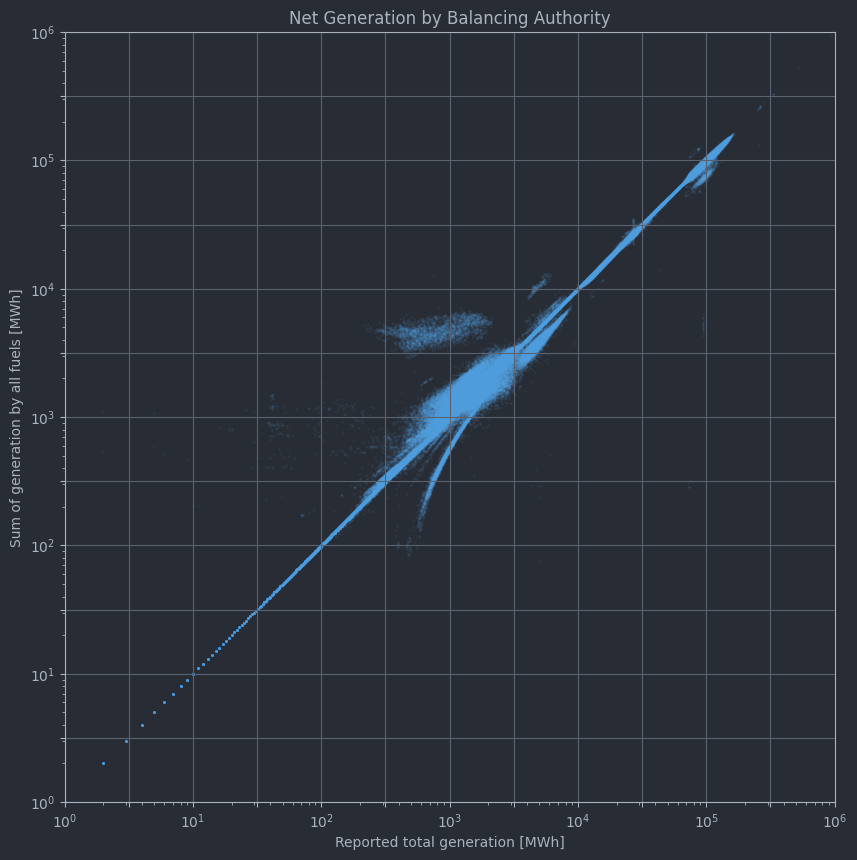

In [5]:
netgen_reported = (
    core_eia930__hourly_operations
    .set_index(
        [
            "balancing_authority_code_eia",
            "datetime_utc",
        ]
    )
    .loc[:, ["net_generation_reported_mwh"]]
).sort_index()

netgen_calculated = core_eia930__hourly_net_generation_by_energy_source.groupby(
        [
            "balancing_authority_code_eia",
            "datetime_utc",
        ]
).net_generation_reported_mwh.sum().sort_index().to_frame()

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(
    netgen_reported.net_generation_reported_mwh,
    netgen_calculated.net_generation_reported_mwh,
    s=1, alpha=0.05,
)
ax.set_xlim(1, 1e6)
ax.set_ylim(1, 1e6)
ax.loglog()
ax.set_aspect("equal")
plt.xlabel("Reported total generation [MWh]")
plt.ylabel("Sum of generation by all fuels [MWh]")
plt.title("Net Generation by Balancing Authority")
plt.grid()
ticks = np.logspace(0, 6, 13)
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

# Reported BA vs. Total of Subregions

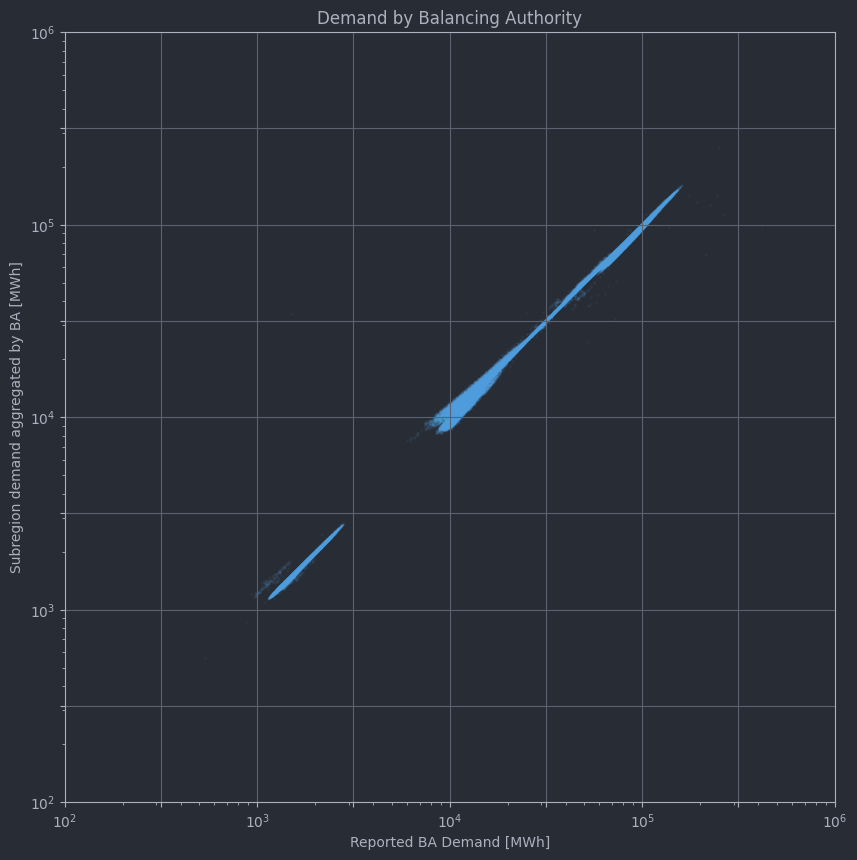

In [6]:
aggregated_ba_demand = core_eia930__hourly_subregion_demand.groupby(
    [
        "balancing_authority_code_eia",
        "datetime_utc",
    ],
    observed=True,
).demand_reported_mwh.sum()
reported_ba_demand = core_eia930__hourly_operations.set_index(
    [
        "balancing_authority_code_eia",
        "datetime_utc",
    ]
).demand_reported_mwh
shared_index = aggregated_ba_demand.index.intersection(reported_ba_demand.index)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(
    reported_ba_demand.loc[shared_index],
    aggregated_ba_demand.loc[shared_index],
    s=1,
    alpha=0.05,
)
ax.set_xlim(1e2, 1e6)
ax.set_ylim(1e2, 1e6)
ax.loglog()
ax.set_aspect("equal")
ticks = np.logspace(2, 6, 9)
plt.xticks(ticks)
plt.yticks(ticks)
ax.grid()
plt.xlabel("Reported BA Demand [MWh]")
plt.ylabel("Subregion demand aggregated by BA [MWh]")
plt.title("Demand by Balancing Authority")
plt.show()

# Calculated vs. Reported Demand

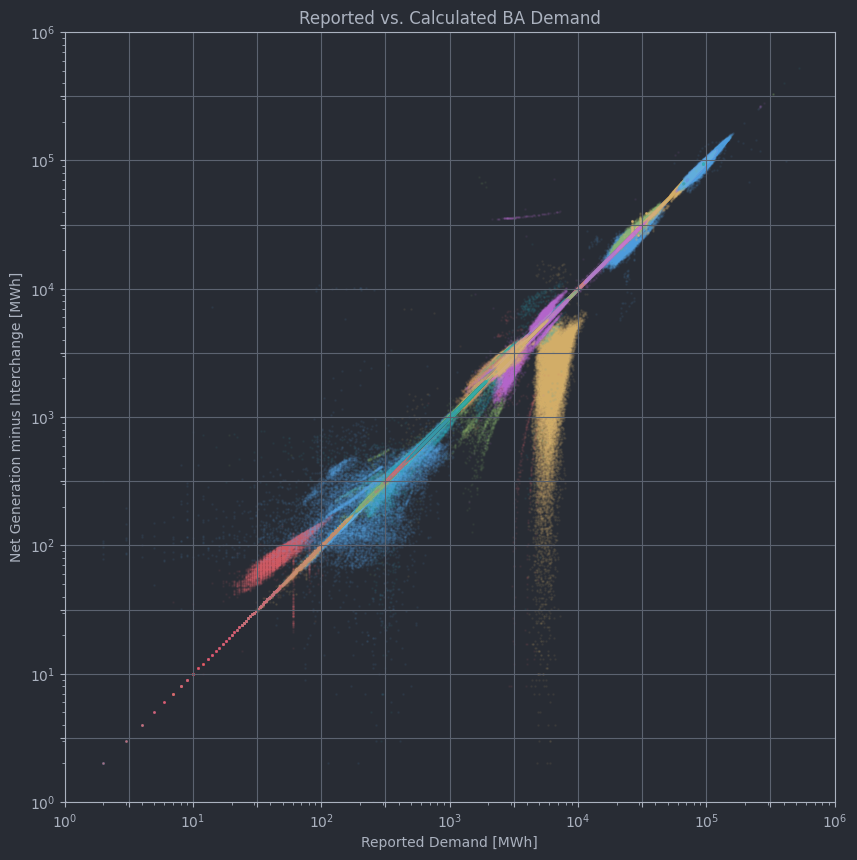

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
ba_ops = core_eia930__hourly_operations
for ba_code in ba_ops.balancing_authority_code_eia.unique():
    ba_data = ba_ops[ba_ops.balancing_authority_code_eia == ba_code]
    ax.scatter(
        ba_data["demand_reported_mwh"],
        ba_data["net_generation_reported_mwh"] - ba_data["interchange_reported_mwh"],
        s=1,
        alpha=0.05,
        label=ba_code,
    )
ax.set_xlim(1e2, 1e6)
ax.set_ylim(1e2, 1e6)
ax.loglog()
ax.set_aspect("equal")
ticks = np.logspace(0, 6, 13)
plt.xticks(ticks)
plt.yticks(ticks)
ax.grid()
plt.xlabel("Reported Demand [MWh]")
plt.ylabel("Net Generation minus Interchange [MWh]")
plt.title("Reported vs. Calculated BA Demand")
plt.show()

# Reported vs. Day-Ahead Forecast Demand

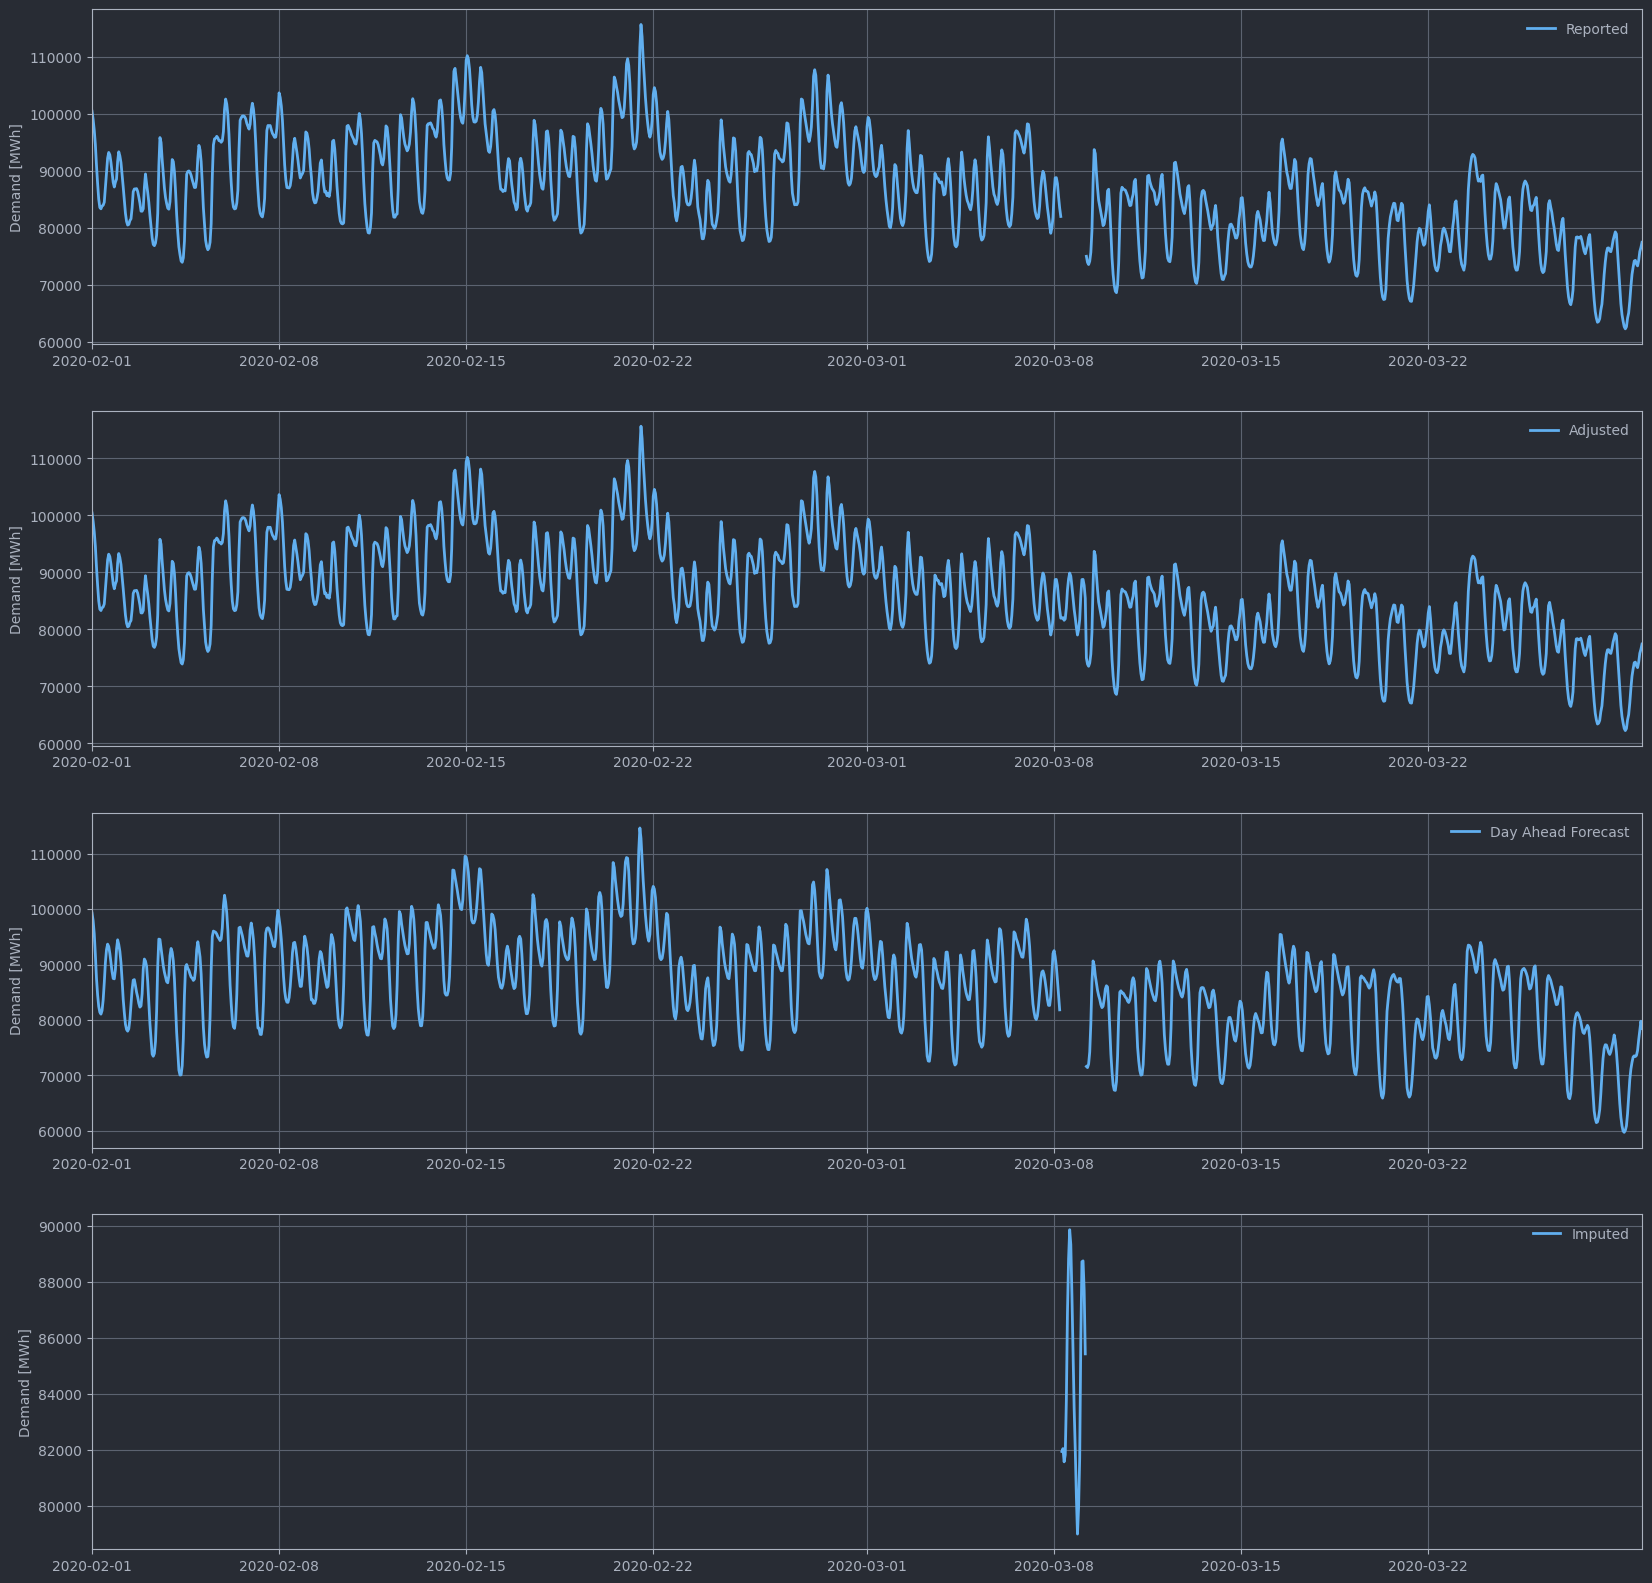

In [8]:
ba_code = "PJM"
start_date = pd.to_datetime("2020-02-01")
end_date = pd.to_datetime("2020-03-30")
ba_demand = core_eia930__hourly_operations.loc[
    (core_eia930__hourly_operations.balancing_authority_code_eia == ba_code)
    & (core_eia930__hourly_operations.datetime_utc.between(start_date, end_date)),
    ["datetime_utc","demand_reported_mwh", "demand_adjusted_mwh", "demand_imputed_eia_mwh", "demand_forecast_mwh"]
].set_index("datetime_utc")

fig, axes = plt.subplots(4, 1, figsize=(20, 20))
axes[0].plot(ba_demand.demand_reported_mwh, label="Reported", lw=2)
axes[1].plot(ba_demand.demand_adjusted_mwh, label="Adjusted", lw=2)
axes[2].plot(ba_demand.demand_forecast_mwh, label="Day Ahead Forecast", lw=2)
axes[3].plot(ba_demand.demand_imputed_eia_mwh, label="Imputed", lw=2)
for ax in axes:
    ax.grid()
    ax.legend()
    ax.set_ylabel("Demand [MWh]")
    ax.set_xlim(start_date, end_date)

plt.show()